# Classifier for the Bank Marketing dataset

## Download the dataset

In [96]:
import pandas as pd
import urllib.request

# Download the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
filename = "bank-additional.zip"

urllib.request.urlretrieve(url, filename)

# Unzip the file
import zipfile
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(".")


In [97]:

# Load the dataset
data = pd.read_csv("bank-additional/bank-additional-full.csv", sep=";")


In [98]:
data['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

**So the dataset is imbalanced !!!!!**

In [99]:

# Print a sample of the dataset
print("First few rows of the dataset:")
print(data.head())

# Print feature names
print("\nFeatures in the dataset:")
print(data.columns.tolist())


First few rows of the dataset:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.c

In [100]:
# Display basic information about the dataset
print("\nDataset info:")
print(data.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   

## Spliting the dataset

In [101]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = data.drop('y', axis=1)
y = data['y']

# First split: Train+Validation and Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Print dataset sizes
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (32950, 20), Test set: (8238, 20)


## Data Preprocessing

### encoding the categorical values
Since most machine learning algorithms require numerical input, we need to convert categorical features into a numerical format without losing the inherent information they carry.

Categorical variables are features that represent categories or groups. They can be divided into two main types:

Nominal Variables: Categories without any intrinsic order or ranking (e.g., job type, marital status).

Ordinal Variables: Categories with a meaningful order or ranking (e.g., education levels).

Categorical Variables in the Dataset

Nominal Variables: job, marital, contact, month, poutcome.

Ordinal Variables: education.

Binary Variables: default, housing, loan, y (target variable).

In [102]:
from sklearn.preprocessing import OrdinalEncoder

# binary encoding
binary_columns = ['default', 'housing', 'loan']

# Convert binary columns to numerical integers 1 and 0
for column in binary_columns:
    X_train[column] = X_train[column].apply(lambda x: 1 if x == "yes" else 0)

# encode the target variable
y_train = y_train.apply(lambda x: 1 if x == "yes" else 0)

#### Handling missing values

Handling 'unknown' Values

Imputing the missing value i.e 'unknown' in the education and contact categories

In [103]:
from sklearn.impute import SimpleImputer
import numpy as np

# Replace unknown values with the most frequent value in the column
imputer = SimpleImputer(strategy="most_frequent")


X_train['education'] = X_train['education'].replace("unknown", np.nan)
X_train['contact'] = X_train['contact'].replace('unnknown', np.nan)
X_train['poutcome'] = X_train['poutcome'].replace('unknown', np.nan)
X_train['marital'] = X_train['marital'].replace('unknown', np.nan)
X_train['job'] = X_train['job'].replace('unknown', np.nan)

# Replace unknown values with the most frequent value in the column
X_train['education'] = imputer.fit_transform(X_train['education'].values.reshape(-1, 1)).ravel()
X_train['contact'] = imputer.fit_transform(X_train['contact'].values.reshape(-1, 1)).ravel()
X_train['poutcome'] = imputer.fit_transform(X_train['poutcome'].values.reshape(-1, 1)).ravel()
X_train['marital'] = imputer.fit_transform(X_train['marital'].values.reshape(-1, 1)).ravel()
X_train['job'] = imputer.fit_transform(X_train['job'].values.reshape(-1, 1)).ravel()

Transform pdays into Two Features

Instead of completely removing pdays, you can split it into two separate features:

- Binary feature: Whether the client was previously contacted.
- Numeric feature: The number of days since last contact for those previously contacted (pdays != 999). Set pdays = 999 to 0 or NaN for those not contacted.

In [104]:
# Binary feature for contact status
X_train['previously_contacted'] = (X_train['pdays'] != 999).astype(int)

# Replace 999 with 0 (or NaN) for the numeric feature
X_train['pdays'] = X_train['pdays'].replace(999, 0)


#### correlation analysis for numeric features

In [105]:
numeric_cols = ['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

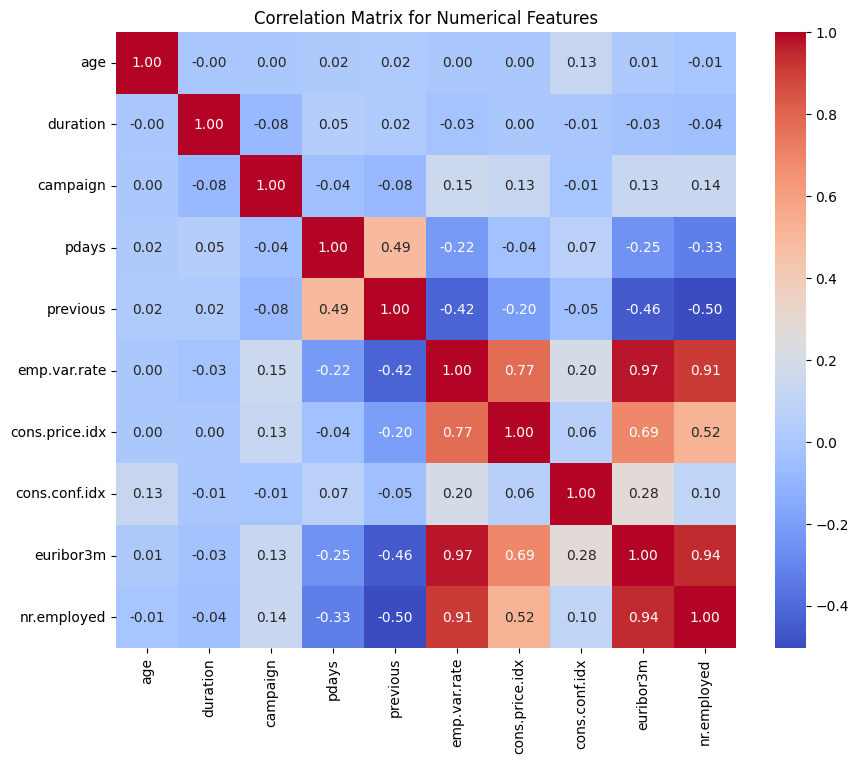

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix for the numeric features
correlation_matrix = X_train[numeric_cols].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Numerical Features")
plt.show()

# Identify pairs of features with high correlation (absolute value > 0.85)
threshold = 0.85
high_corr_pairs = correlation_matrix.where(
    (correlation_matrix.abs() > threshold) & (correlation_matrix!= 1.0)
)

# Convert the pairs to a readable format
high_corr_features = high_corr_pairs.stack().reset_index()
high_corr_features.columns = ['Feature1', 'Feature2', 'Correlation']

# Display the list of highly correlated feature pairs
high_corr_features_sorted = high_corr_features.sort_values(by='Correlation', ascending=False)

In [107]:
features_to_drop = ['euribor3m']

X_train = X_train.drop(columns=features_to_drop)

#### Encoding

In [108]:
# use the ordinal encoder to encode the education column
education_order = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y',
                   'high.school', 'professional.course', 'university.degree']
ord_enc = OrdinalEncoder(categories=[education_order])
X_train["education"] = ord_enc.fit_transform(X_train[["education"]])


In [109]:
# now encode the remaining categorical columns
categorical_columns = ['job', 'marital', 'contact', 'month', 'poutcome', 'day_of_week']

Using drop_first=True in one-hot encoding is a common and recommended practice to prevent multicollinearity in models that are sensitive to it, such as linear and logistic regression. Dropping one dummy variable does not negatively impact your model's ability to make accurate predictions because the information about the dropped category is still present implicitly. The model interprets the absence of all other categories as belonging to the reference category.

In [110]:
X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True, dtype=int)

In [111]:
X_train.columns

Index(['age', 'education', 'default', 'housing', 'loan', 'duration',
       'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'nr.employed', 'previously_contacted',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'contact_telephone', 'month_aug', 'month_dec',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_nonexistent', 'poutcome_success',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed'],
      dtype='object')

In [112]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32950 entries, 25611 to 10747
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   32950 non-null  int64  
 1   education             32950 non-null  float64
 2   default               32950 non-null  int64  
 3   housing               32950 non-null  int64  
 4   loan                  32950 non-null  int64  
 5   duration              32950 non-null  int64  
 6   campaign              32950 non-null  int64  
 7   pdays                 32950 non-null  int64  
 8   previous              32950 non-null  int64  
 9   emp.var.rate          32950 non-null  float64
 10  cons.price.idx        32950 non-null  float64
 11  cons.conf.idx         32950 non-null  float64
 12  nr.employed           32950 non-null  float64
 13  previously_contacted  32950 non-null  int64  
 14  job_blue-collar       32950 non-null  int64  
 15  job_entrepreneur    

In [113]:
X_train.columns

Index(['age', 'education', 'default', 'housing', 'loan', 'duration',
       'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'nr.employed', 'previously_contacted',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'contact_telephone', 'month_aug', 'month_dec',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_nonexistent', 'poutcome_success',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed'],
      dtype='object')

In [114]:
print(X_train.head())

       age  education  default  housing  loan  duration  campaign  pdays  \
25611   49        3.0        0        0     0       227         4      0   
26010   37        6.0        0        0     0       202         2      0   
40194   78        1.0        0        0     0      1148         1      0   
297     36        6.0        0        1     0       120         2      0   
36344   59        6.0        0        0     0       368         2      0   

       previous  emp.var.rate  ...  month_may  month_nov  month_oct  \
25611         0          -0.1  ...          0          1          0   
26010         1          -0.1  ...          0          1          0   
40194         0          -1.7  ...          0          0          0   
297           0           1.1  ...          1          0          0   
36344         0          -2.9  ...          0          0          0   

       month_sep  poutcome_nonexistent  poutcome_success  day_of_week_mon  \
25611          0                     1 

### now processing the numeric features

#### Normalizing the features

Normalize Continuous Numerical Features: Especially when they have different scales.

Normalization Improves Algorithm Performance: For algorithms sensitive to feature scales.

Use Appropriate Scaling Method: Choose between StandardScaler, MinMaxScaler, or RobustScaler based on data distribution and presence of outliers.

Apply Scaling After Splitting Data: To prevent data leakage and ensure that the scaler is not influenced by the testing data.

Different types of normalization

1. Min-Max Scaling (Normalization)
Transforms features to a fixed range, usually [0, 1].

When to Use:

When you know the boundaries of your data.

Useful for algorithms that do not assume a normal distribution.



2. Standardization (Z-score Normalization)
Centers the data around the mean with a standard deviation of 1.

When to Use:

When the data follows a normal distribution.

For algorithms that assume standard normal distribution.



3. Robust Scaling
Uses median and interquartile range, making it robust to outliers.

When to Use:

When your data contains outliers.

**Practical Workflow:**

1. Start with Descriptive Statistics: Summarize key metrics like mean, median, min, max, and standard deviation.
2. Visualize Distribution: Use histograms and KDE plots to assess normality and skewness.
3. Detect Outliers: Generate box plots and scatter plots to identify outliers.
4. Compare Scales: Use side-by-side box plots or overlapping density plots to examine differences in feature ranges.
5. Choose a Method:
    - Min-Max Scaling: Features have different ranges but no outliers.
    - Standardization: Gaussian distribution with comparable scales.
    - Robust Scaling: Outliers are present.
    - Log Transformation: Data is heavily skewed.

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

class NumericFeatureAnalyzer:
    def __init__(self, dataframe, numeric_features, target=None):
        """
        Initialize the NumericFeatureAnalyzer class.
        :param dataframe: Pandas DataFrame containing the dataset.
        :param target: Target variable column name (optional).
        """
        self.df = dataframe
        self.numeric_features = numeric_features
        self.target = target
        self.results = {}

    def analyze_feature(self, feature):
        """
        Performs analysis and visualization for a numeric feature.
        :param feature: Name of the numeric feature.
        """
        print(f"Analysis for Feature: {feature}")
        print("-" * 50)
        print(f"Descriptive Statistics:\n{self.df[feature].describe()}\n")
        
        # Histogram and KDE
        plt.figure(figsize=(12, 6))
        sns.histplot(self.df[feature], kde=True, bins=30, color='blue', label='Distribution')
        plt.title(f"{feature} - Histogram & KDE")
        plt.legend()
        plt.show()

        # Box plot for outliers
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=self.df[feature], color='green')
        plt.title(f"{feature} - Boxplot for Outliers")
        plt.show()
        
        # Correlation with target (if applicable)
        if self.target:
            correlation = self.df[[feature, self.target]].corr().iloc[0, 1]
            print(f"Correlation with Target ({self.target}): {correlation}\n")
        
        print("-" * 50)

    def simulate_normalization(self, feature):
        """
        Simulates the effect of different normalization techniques on a feature.
        :param feature: Name of the numeric feature.
        """
        data = self.df[feature].dropna().values.reshape(-1, 1)
        scalers = {
            "Min-Max Scaling": MinMaxScaler(),
            "Standardization (Z-Score)": StandardScaler(),
            "Robust Scaling": RobustScaler(),
        }
        
        plt.figure(figsize=(12, 8))
        for i, (name, scaler) in enumerate(scalers.items(), 1):
            transformed_data = scaler.fit_transform(data)
            plt.subplot(2, 2, i)
            sns.histplot(transformed_data, kde=True, bins=30, color='purple')
            plt.title(f"{name} on {feature}")
        plt.tight_layout()
        plt.show()

    def recommend_normalization(self, feature):
        """
        Recommends normalization technique based on feature analysis.
        :param feature: Name of the numeric feature.
        """
        skewness = self.df[feature].skew()
        print(f"Skewness for {feature}: {skewness}")
        if skewness > 1 or skewness < -1:
            print(f"Recommended: Log Transformation or Robust Scaling for {feature}")
            self.results[feature] = "Log Transformation or Robust Scaling"
        elif self.df[feature].min() < 0 or self.df[feature].max() > 1:
            print(f"Recommended: Standardization (Z-Score) for {feature}")
            self.results[feature] = "Standardization (Z-Score)"
        else:
            print(f"Recommended: Min-Max Scaling for {feature}")
            self.results[feature] = "Min-Max Scaling"
        print("-" * 50)

    def perform_analysis(self):
        """
        Performs the entire workflow for numeric feature analysis and normalization.
        """
        for feature in self.numeric_features:
            print(f"\n{'=' * 60}\nAnalyzing {feature}\n{'=' * 60}")
            self.analyze_feature(feature)
            self.simulate_normalization(feature)
            self.recommend_normalization(feature)



Analyzing age
Analysis for Feature: age
--------------------------------------------------
Descriptive Statistics:
count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64



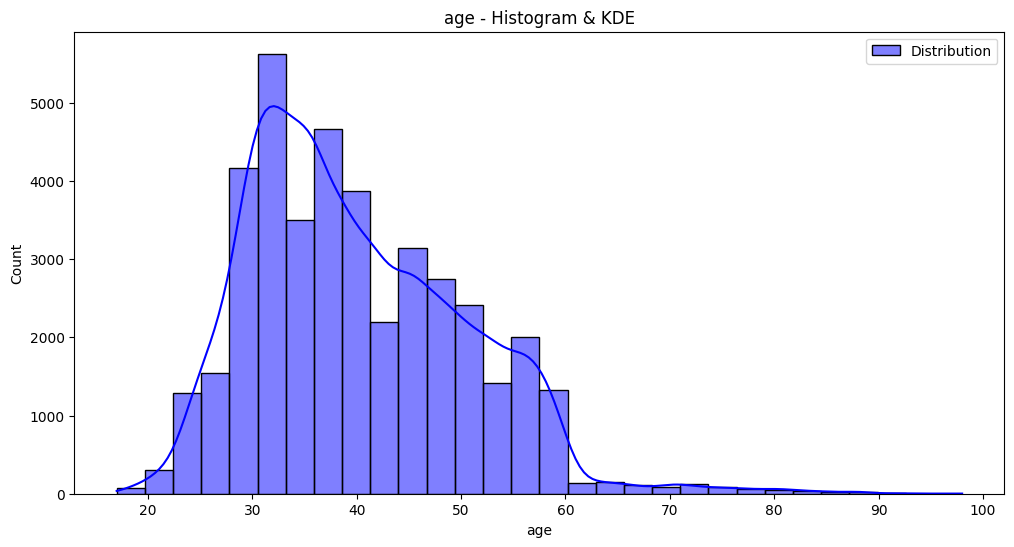

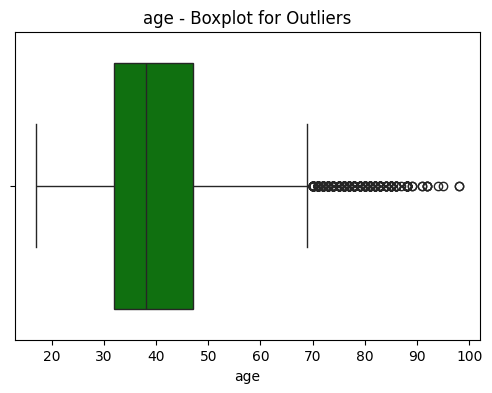

ValueError: could not convert string to float: 'no'

In [139]:
# Instantiate the class with the dataset and target variable
analyzer = NumericFeatureAnalyzer(dataframe=X_train, numeric_features=numeric_cols, target='y')

# Perform the analysis
analyzer.perform_analysis()


In [ ]:
# analyzer.results

| **Feature**        | **Recommended Normalization**            | **Reason**                                                                                  | **Additional Notes**                                                                                           |
|---------------------|------------------------------------------|--------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------|
| **age**            | Standardization (Z-Score)               | Moderately symmetric distribution (skewness ~0.78).                                        | Outliers are present but not extreme enough to justify robust scaling.                                        |
| **duration**       | Log Transformation or Robust Scaling    | Heavily skewed distribution (skewness = 3.26) with a long tail of outliers.                | `duration` strongly correlates with the target (r = 0.41) and should be used cautiously to avoid model bias.  |
| **campaign**       | Log Transformation or Robust Scaling    | Highly right-skewed (skewness = 4.76) with extreme outliers (e.g., max = 56).              | Outliers represent clients contacted unusually frequently. Log transformation reduces the skew effectively.    |
| **pdays**          | Log Transformation or Robust Scaling    | Extremely skewed distribution due to dominance of `999` (skewness = -4.92).                | Treat `999` as a categorical indicator for "not previously contacted" and preprocess numeric values (0–998). |
| **previous**       | Log Transformation or Robust Scaling    | Skewed distribution with outliers.                                                        | Small values dominate; log transformation will compress the range and normalize the scale.                   |
| **emp.var.rate**   | Standardization (Z-Score)               | Normally distributed (approximately symmetric).                                            | Directly suitable for Z-score standardization.                                                               |
| **cons.price.idx** | Standardization (Z-Score)               | Approximate Gaussian distribution with moderate spread.                                    | Standardization will center and scale effectively.                                                           |
| **cons.conf.idx**  | Standardization (Z-Score)               | Approximate Gaussian distribution with moderate spread.                                    | Standardization will center and scale effectively.                                                           |
| **euribor3m**      | Standardization (Z-Score)               | Symmetric distribution with a consistent range.                                            | No significant skew or outliers detected.                                                                    |
| **nr.employed**    | Log Transformation or Robust Scaling    | Skewed distribution with outliers.                                                        | Log transformation is better for handling the long tail.                                                     |


In [117]:
X_train

,age,education,default,housing,loan,duration,campaign,pdays,previous,emp.var.rate,...,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
25611,49,3.0,0,0,0,227,4,0,0,-0.1,...,0,1,0,0,1,0,0,0,0,1
26010,37,6.0,0,0,0,202,2,0,1,-0.1,...,0,1,0,0,0,0,0,0,0,1
40194,78,1.0,0,0,0,1148,1,0,0,-1.7,...,0,0,0,0,1,0,1,0,0,0
297,36,6.0,0,1,0,120,2,0,0,1.1,...,1,0,0,0,1,0,1,0,0,0
36344,59,6.0,0,0,0,368,2,0,0,-2.9,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40205,28,4.0,0,1,0,192,1,0,0,-1.7,...,0,0,0,0,1,0,0,0,1,0
27316,52,5.0,0,1,0,64,1,0,1,-0.1,...,0,1,0,0,0,0,0,0,0,0
14392,54,3.0,0,0,1,131,4,0,0,1.4,...,0,0,0,0,1,0,1,0,0,0
7494,29,6.0,0,0,0,165,1,0,0,1.1,...,1,0,0,0,1,0,0,0,0,0


In [118]:
from sklearn.preprocessing import StandardScaler

# Mapping recommended normalization techniques to features
normalization_map = {
    'age': 'Standardization (Z-Score)',
    'duration': 'Log Transformation',
    'campaign': 'Log Transformation',
    'pdays': 'Log Transformation',
    'previous': 'Log Transformation',
    'emp.var.rate': 'Standardization (Z-Score)',
    'cons.price.idx': 'Standardization (Z-Score)',
    'cons.conf.idx': 'Standardization (Z-Score)',
    # 'euribor3m': 'Standardization (Z-Score)',
    'nr.employed': 'Log Transformation'
}

def apply_normalization(data,feature, technique):
    if technique == 'Standardization (Z-Score)':
        data[feature] = StandardScaler().fit_transform(data[[feature]])
    elif technique == 'Log Transformation':
        # Apply Log Transformation first (add 1 to avoid log(0))
        data[feature] = np.log1p(X_train[feature])


In [119]:
for feature, technique in normalization_map.items():
    apply_normalization(X_train,feature, technique)

In [120]:
X_train

,age,education,default,housing,loan,duration,campaign,pdays,previous,emp.var.rate,...,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
25611,0.863739,3.0,0,0,0,5.429346,1.609438,0.0,0.000000,-0.114858,...,0,1,0,0,1,0,0,0,0,1
26010,-0.289722,6.0,0,0,0,5.313206,1.098612,0.0,0.693147,-0.114858,...,0,1,0,0,0,0,0,0,0,1
40194,3.651268,1.0,0,0,0,7.046647,0.693147,0.0,0.000000,-1.133161,...,0,0,0,0,1,0,1,0,0,0
297,-0.385843,6.0,0,1,0,4.795791,1.098612,0.0,0.000000,0.648868,...,1,0,0,0,1,0,1,0,0,0
36344,1.824956,6.0,0,0,0,5.910797,1.098612,0.0,0.000000,-1.896888,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40205,-1.154817,4.0,0,1,0,5.262690,0.693147,0.0,0.000000,-1.133161,...,0,0,0,0,1,0,0,0,1,0
27316,1.152104,5.0,0,1,0,4.174387,0.693147,0.0,0.693147,-0.114858,...,0,1,0,0,0,0,0,0,0,0
14392,1.344347,3.0,0,0,1,4.882802,1.609438,0.0,0.000000,0.839800,...,0,0,0,0,1,0,1,0,0,0
7494,-1.058695,6.0,0,0,0,5.111988,0.693147,0.0,0.000000,0.648868,...,1,0,0,0,1,0,0,0,0,0


In [121]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32950 entries, 25611 to 10747
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   32950 non-null  float64
 1   education             32950 non-null  float64
 2   default               32950 non-null  int64  
 3   housing               32950 non-null  int64  
 4   loan                  32950 non-null  int64  
 5   duration              32950 non-null  float64
 6   campaign              32950 non-null  float64
 7   pdays                 32950 non-null  float64
 8   previous              32950 non-null  float64
 9   emp.var.rate          32950 non-null  float64
 10  cons.price.idx        32950 non-null  float64
 11  cons.conf.idx         32950 non-null  float64
 12  nr.employed           32950 non-null  float64
 13  previously_contacted  32950 non-null  int64  
 14  job_blue-collar       32950 non-null  int64  
 15  job_entrepreneur    

## Feature Engineering

### PCA

use standard after log wala normalization

In [123]:
from sklearn.decomposition import PCA

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.90)  # Retain 95% variance
data_pca = pca.fit_transform(X_train)

# Check the number of components
print(f"Number of components explaining 95% variance: {pca.n_components_}")


Number of components explaining 95% variance: 15


make this graph better , all the other features also

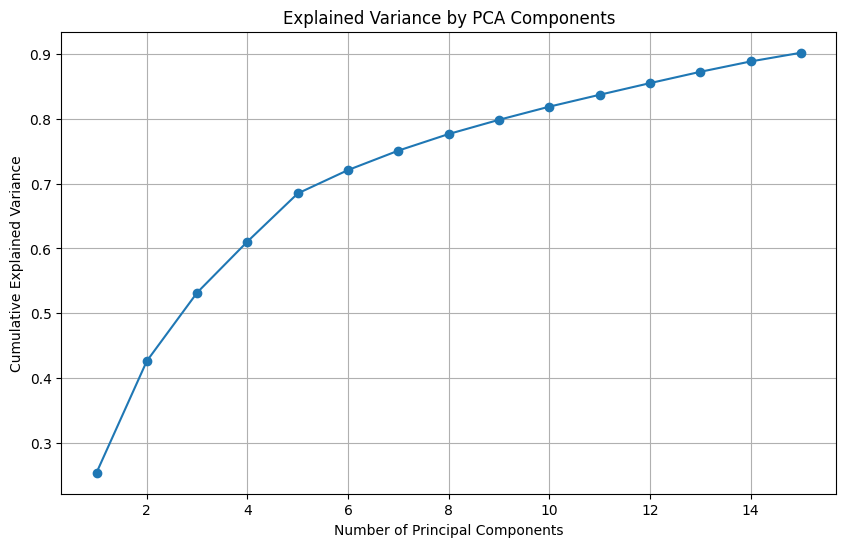

In [124]:
# Cumulative explained variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()


In [125]:
# Convert PCA-transformed data into a DataFrame
pca_columns = [f'PC{i+1}' for i in range(data_pca.shape[1])]
X_pca_df = pd.DataFrame(data_pca, columns=pca_columns)

# Display the PCA-transformed data
# print(X_pca_df.head())


In [126]:
# Feature contributions to each principal component
feature_contributions = pd.DataFrame(pca.components_, columns=X_train.columns, index=pca_columns)
# print(feature_contributions)


In [127]:
# Get absolute contributions for better interpretation
components_contributions = np.abs(pca.components_)

# Create a dictionary with PCs and their top contributing features
top_features_per_pc = {
    f'PC{i+1}': [
        X_train.columns[idx] for idx in np.argsort(components_contributions[i])[::-1][:5]  # Top 5 features
    ]
    for i in range(pca.n_components_)
}


In [128]:
from pprint import pprint

pprint(top_features_per_pc)

{'PC1': ['education',
         'cons.price.idx',
         'age',
         'job_blue-collar',
         'emp.var.rate'],
 'PC10': ['campaign',
          'day_of_week_mon',
          'day_of_week_tue',
          'duration',
          'day_of_week_wed'],
 'PC11': ['day_of_week_thu',
          'day_of_week_mon',
          'campaign',
          'month_may',
          'month_jun'],
 'PC12': ['day_of_week_wed',
          'day_of_week_mon',
          'day_of_week_thu',
          'day_of_week_tue',
          'campaign'],
 'PC13': ['day_of_week_tue',
          'day_of_week_wed',
          'day_of_week_thu',
          'day_of_week_mon',
          'month_may'],
 'PC14': ['month_may', 'month_jun', 'day_of_week_mon', 'emp.var.rate', 'pdays'],
 'PC15': ['job_technician',
          'job_blue-collar',
          'month_jul',
          'month_aug',
          'job_services'],
 'PC2': ['emp.var.rate',
         'cons.price.idx',
         'cons.conf.idx',
         'contact_telephone',
         'education'],
 

## Classifier

### SVM & Logistic Regression

In [129]:
X_pca_df.shape

(32950, 15)

In [130]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


# Define the SVM classifier
svm_clf = SVC(kernel='rbf', C=1, random_state=42)


# Define the logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

#### Hyper parameter tuning using cross-validation

**Explanation of paramteters of logistic regression**

Explanation
- C (Regularization Strength): Regularization prevents overfitting by adding a penalty to large coefficients. C is the inverse of the regularization strength:
    - Smaller values (e.g., C=0.01) imply stronger regularization (simpler models).
    - Larger values (e.g., C=100) imply weaker regularization (complex models).
    - Tuning C helps balance bias (underfitting) and variance (overfitting).

- solver (Optimization Algorithm):Logistic regression uses different algorithms to optimize the cost function:
    - lbfgs: 
        - Efficient for small-to-medium datasets. 
        -Supports l2 regularization (ridge regression penalty).
    - liblinear:
        - Suitable for smaller datasets. 
        - Supports l1 (lasso) and l2 penalties.

**C (Regularization Parameter):**

- Controls the trade-off between the margin width and classification error:
  - **Smaller values** (e.g., `C=0.1`): 
    - Result in a wider margin (simpler models with fewer support vectors).
  - **Larger values** (e.g., `C=10`): 
    - Result in a narrower margin, allowing the model to fit the data more closely (complex models).

---

**kernel (Kernel Type):**

- Defines the function to transform data into higher dimensions for better separation:
  - **`linear`:**
    - No transformation; works well for linearly separable data.
  - **`rbf` (Radial Basis Function):**
    - Non-linear kernel; transforms data to find non-linear decision boundaries.
    - Suitable for most problems.
  - **`poly` (Polynomial Kernel):**
    - Fits decision boundaries of polynomial shapes.
    - Controlled by the `degree` parameter (not in this grid).

---

**gamma (Kernel Coefficient):**

- Determines the influence of individual data points for `rbf` and `poly` kernels:
  - **`scale`:**
    - Calculates gamma as:
      \[
      \gamma = \frac{1}{\text{number of features}}
      \]
    - Adapts automatically to the dataset.
  - **`auto`:**
    - Calculates gamma as:
      \[
      \gamma = \frac{1}{\text{number of samples}}
      \]
    - May result in higher values, leading to more complex models.


add more params in the lr grid

In [131]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], # Regularization parameter (inverse of lambda)
    'solver': ['lbfgs', 'liblinear'] # Optimization algorithm
    
}

svm_param_grid = { 
    'C': [0.1, 1, 10], # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'], # Kernel type
    'gamma': ['scale', 'auto'] # Kernel coefficient
} 

# since the dataset is imbalanced, we will use the f1 score as the scoring metric
scoring_metric = 'f1'

Grid search for SVM

In [132]:
# Set up GridSearchCV
svm_grid_search = GridSearchCV(estimator=svm_clf, param_grid=svm_param_grid, cv=5, scoring=scoring_metric, n_jobs=-1)

# Perform the grid search
svm_grid_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best parameters for SVM:", svm_grid_search.best_params_)
print(f"Best cross-validation {scoring_metric} for SVM:", svm_grid_search.best_score_)


Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'poly'}
Best cross-validation f1 for SVM: 0.5018264018818679


Grid search for Logistic Regression

In [133]:
# Set up GridSearchCV
lr_grid_search = GridSearchCV(
    estimator=lr_clf,
    param_grid=lr_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=scoring_metric,  # Use accuracy as the evaluation metric
    n_jobs=-1  # Use all available cores
)

# Perform the grid search
lr_grid_search.fit(X_train, y_train)

# Get the best parameters and cross-validation score
print("Best parameters for Logistic Regression (GridSearch):", lr_grid_search.best_params_)
print(f"Best cross-validation {scoring_metric} (GridSearch):", lr_grid_search.best_score_)

Best parameters for Logistic Regression (GridSearch): {'C': 100, 'solver': 'lbfgs'}
Best cross-validation f1 (GridSearch): 0.5235900629536338


Randomized Search for SVM

In [134]:
# Set up RandomizedSearchCV
svm_random_search = RandomizedSearchCV(
    estimator=svm_clf,
    param_distributions=svm_param_grid,
    n_iter=100,  # Number of parameter settings to try
    cv=5,       # 5-fold cross-validation
    scoring=scoring_metric,  # Metric to evaluate
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the randomized search
svm_random_search.fit(X_train, y_train)

# Get the best parameters and cross-validation score
print("Best parameters for SVM:", svm_random_search.best_params_)
print(f"Best cross-validation {scoring_metric} for SVM:", svm_random_search.best_score_)


Best parameters for SVM: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
Best cross-validation f1 for SVM: 0.48669598985430423


Randomized Search for Logistic Regression

In [135]:
# Set up RandomizedSearchCV
lr_random_search = RandomizedSearchCV(
    estimator=lr_clf,
    param_distributions=lr_param_grid,
    n_iter=7,  # Number of parameter settings to try
    cv=5,  # 5-fold cross-validation
    scoring=scoring_metric,  # Use accuracy as the evaluation metric
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the randomized search
lr_random_search.fit(X_train, y_train)

# Get the best parameters and cross-validation score
print("Best parameters for Logistic Regression (RandomizedSearch):", lr_random_search.best_params_)
print(f"Best cross-validation {scoring_metric} (RandomizedSearch):", lr_random_search.best_score_)


Best parameters for Logistic Regression (RandomizedSearch): {'solver': 'lbfgs', 'C': 100}
Best cross-validation f1 (RandomizedSearch): 0.5235900629536338


#### Model Selection

In [136]:
# Compare the cross-validation scores for SVM and Logistic Regression

# Get the best cross-validation scores
svm_best_cv_score = svm_random_search.best_score_
lr_best_cv_score = lr_random_search.best_score_

# Print cross-validation scores
print("Best Cross-Validation Score for SVM:", svm_best_cv_score)
print("Best Cross-Validation Score for Logistic Regression:", lr_best_cv_score)

# Compare models
if svm_best_cv_score > lr_best_cv_score:
    print("Based on cross-validation, the SVM model performs better.")
    best_model = svm_random_search.best_estimator_
else:
    print("Based on cross-validation, the Logistic Regression model performs better.")
    best_model = lr_random_search.best_estimator_

# Output the selected model
best_model


Best Cross-Validation Score for SVM: 0.48669598985430423
Best Cross-Validation Score for Logistic Regression: 0.5235900629536338
Based on cross-validation, the Logistic Regression model performs better.


LogisticRegression(C=100, max_iter=1000, random_state=42)

In [137]:
# now evaluate performace on training data

from sklearn.metrics import classification_report

# Make predictions on the training set
y_train_pred = best_model.predict(X_train)

# Display classification report

print("Classification Report (Training Set):")
print(classification_report(y_train, y_train_pred))


Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     29238
           1       0.66      0.44      0.53      3712

    accuracy                           0.91     32950
   macro avg       0.80      0.70      0.74     32950
weighted avg       0.90      0.91      0.90     32950



In [138]:
# # now evaluate performace on test data

# # Make predictions on the test set
# y_test_pred = best_model.predict(X_test)

# # Display classification report
# print("Classification Report (Test Set):")
# print(classification_report(y_test, y_test_pred))